# Supervised Machine Learning: Random Forest Regressor

## Building and mineral model from a pulsed neutron log.

A random forest model is common method comprised of a group of decision trees. We will be using scikit learn's [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) estimator.

In [1]:
import pandas as pd
import lasio
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pickle

%matplotlib inline  

pd.set_option('max_columns',30)
pd.set_option('max_rows',10)

import warnings

For demonstration puropses we are going to use one pused neutron log for training data. If you were to be doing this for a deployable model you'd want to use more training data.

In [2]:
las = lasio.read("data/Logs/0504511399_2355551.LAS.txt")
las_df = las.df()

#Preview our data
las_df.head()

,AF10,AF20,AF30,AF60,AF90,AO10,AO20,AO30,AO60,AO90,AT10,AT20,AT30,AT60,AT90,...,RXO8,RXOZ,SP,SPAR,STIT,TENS,TNPH,WANH_WALK2,WCAR_WALK2,WCLA_WALK2,WCOA_WALK2,WEVA_WALK2,WPYR_WALK2,WQFM_WALK2,WSID_WALK2
DEPT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7766.0,1950.0,0.4189,48.9485,90.6788,405.7715,1950.0,0.5657,52.9586,61.696,199.9016,1950.0,0.5223,47.5416,87.1146,337.7076,...,671.9650,925.7877,2035.3125,2035.4362,0.0,3321.0,0.2096,0.0,0.0548,0.3298,0.0,0.0,0.0,0.6153,0.0
7766.5,1950.0,0.4189,48.9485,90.6788,405.7715,1950.0,0.5657,52.9586,61.696,199.9016,1950.0,0.5223,47.5416,87.1146,337.7076,...,671.9650,925.7877,2036.6875,2036.5858,0.0,3293.0,0.2096,0.0,0.0548,0.3298,0.0,0.0,0.0,0.6153,0.0
7767.0,1950.0,0.4189,48.9485,90.6788,405.7715,1950.0,0.5657,52.9586,61.696,199.9016,1950.0,0.5223,47.5416,87.1146,337.7076,...,671.9650,925.7877,2039.8750,2040.0656,0.0,3296.0,0.2096,0.0,0.0548,0.3298,0.0,0.0,0.0,0.6153,0.0
7767.5,1950.0,0.4189,48.9485,90.6788,405.7715,1950.0,0.5657,52.9586,61.696,199.9016,1950.0,0.5223,47.5416,87.1146,337.7076,...,718.2645,2.8226,2042.9375,2042.9786,0.0,3295.0,0.1972,0.0,0.0548,0.3298,0.0,0.0,0.0,0.6153,0.0
7768.0,1950.0,0.4189,48.9485,90.6788,405.7715,1950.0,0.5657,52.9586,61.696,199.9016,1950.0,0.5223,47.5416,87.1146,337.7076,...,0.4487,0.5414,2042.6250,2042.4243,0.0,3284.0,0.1894,0.0,0.0548,0.3298,0.0,0.0,0.0,0.6153,0.0


In [3]:
#Pull the Non-Walk Curves
curves = {}
for x in las.curves[1:]: 
    #Skip Pulsed Neutron Logs
    if 'WALK' in x['mnemonic']: continue
    
    curves[x['mnemonic']] = x['descr']

print(list(curves.keys()))

['AF10', 'AF20', 'AF30', 'AF60', 'AF90', 'AO10', 'AO20', 'AO30', 'AO60', 'AO90', 'AT10', 'AT20', 'AT30', 'AT60', 'AT90', 'AFCO', 'AORT', 'AORX', 'ASFI', 'ATCO', 'CDF', 'CFTC', 'CNTC', 'CTEM', 'DCAL', 'DNPH', 'DPHZ', 'DPH8', 'DSOZ', 'ECGR', 'ECST', 'GDEV', 'GR', 'GTEM', 'HCAL', 'HCGR', 'HDRA', 'HDRB', 'HFK', 'HGR', 'HMIN', 'HMNO', 'HNPO', 'HPRA', 'HSGR', 'HTHO', 'HTNP', 'HURA', 'NPHI', 'NPOR', 'PEF8', 'PEFZ', 'PXND_HILT', 'QCPMT', 'RHO8', 'RHOZ', 'RSOZ', 'RXO8', 'RXOZ', 'SP', 'SPAR', 'STIT', 'TENS', 'TNPH']


In [4]:
#Our Possible Outcome Columns
pn_cols = { "WANH_WALK2" : 'Anhydrite',
            "WCAR_WALK2" : 'Carbonate',
            "WCLA_WALK2" : 'Clay',
            "WCOA_WALK2" : 'Coal',
            "WEVA_WALK2" : 'Salt',
            "WPYR_WALK2" : 'Pyrite',
            "WQFM_WALK2" : 'QFM',
            "WSID_WALK2" : 'Siderite'}

#Use Only Columns Have Detections
pn_usable = list(pn_cols.keys())
for col in pn_cols.keys():
    min_s = las_df[col].describe()['min']
    prec_detect = round(las_df[las_df[col] > min_s].shape[0]/las_df.shape[0]*100,0)
    if prec_detect <= 2:
        pn_usable.remove(col)

print(', '.join([pn_cols[x] for x in pn_usable]), 'found in >2% of samples.')

Carbonate, Clay, Pyrite, QFM found in >2% of samples.


In [5]:
#Drop Null Values
subset = list(curves.keys()) + list(pn_usable)
las_df.dropna(subset=subset, inplace=True)

#Seperate Our Training & Outcome Data
X = las_df[curves.keys()]
y = las_df[pn_usable]

#Split off 10% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

#Set up our model; no randomness in bootstrapping with depth & trees counts set low for demo purposes
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=20)

#Train our model
regr.fit(X_train, y_train)

#Test outcome
print('Model Score:',round(regr.score(X_test, y_test),3))

Model Score: 0.378


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


## Hyperparameter Tuning

Think of this as tweaking the inputs of our algorithm to enhance performance.  One of the first things we will do before repeditavely running a model is to decrease the number of parameters by choosing those with the most influence on the outcome of our model. This allows us to run multiple iterations faster to demonstrate visually what happens as we adjust our model inputs while minimizing the impact on score.  We do risk eliminating a minor predictor feature by doing this but it's contribution to accuracy will be minor.

The ultimate goal is to minimize error.  If our model is two simple we will not capture details present in the training data that represents the real world.  If we make our model too complex, or overfit, changes in our training data introduce error.  To decrease the irreducable error once the prior two are optimized we must have a more represenative dataset of the real world. Usually this means using a larger training dataset but eleminating sampling bias is also important.

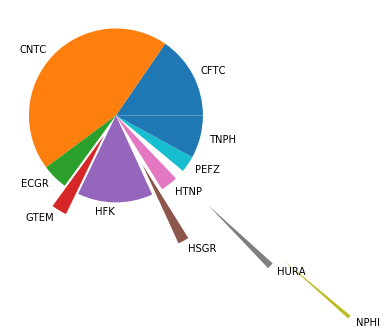

In [6]:
#Dropping non-contributers
feats = []
labels = []
for score, mnemonic in zip(regr.feature_importances_, curves.keys()):
    #Filter out curves that did not contribute first pass
    if score == 0: 
        continue
    
    else:
        feats.append(score)
        labels.append(mnemonic)

##Visualize Those Curves' Contribution to Model
explode = [0 if x > 0.03 else 5*(1-x)**100 for x  in feats]
plt.pie(feats,labels=labels,explode=explode)
plt.show()

So with just filtering the inputs to our model to those that contributed on the first pass how does that affect the score?  

Model Score: 0.511


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


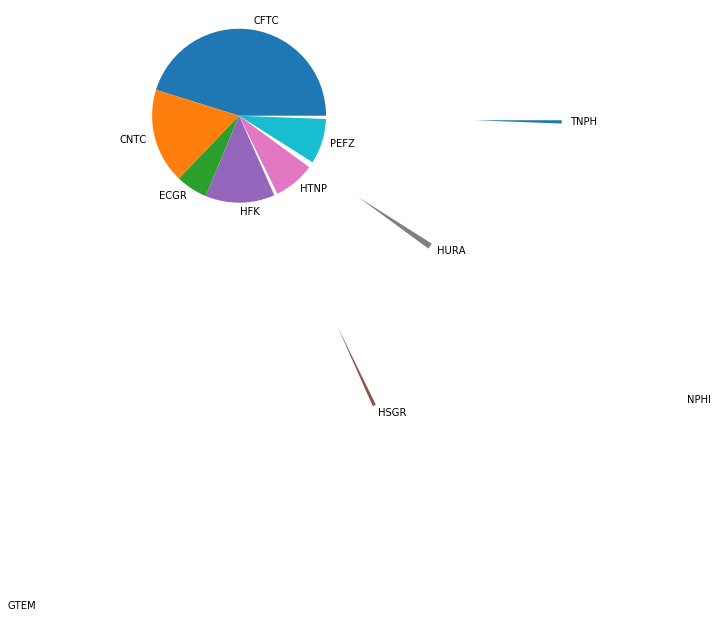

In [7]:
#Drop Null Values
subset = labels + pn_usable
las_df.dropna(subset=subset, inplace=True)

X = las_df[labels]
y = las_df[pn_cols.keys()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=20)
regr.fit(X_train, y_train)
print('Model Score:',round(regr.score(X_test, y_test),3))

##Visualize Those Curves' Contribution to Model
explode = [0 if x > 0.03 else 5*(1-x)**100 for x  in regr.feature_importances_]
plt.pie(regr.feature_importances_,labels=labels,explode=explode)
plt.show()


---

## Number of Trees
Now let's look at the affect of changing `n_estimators` or the number of trees in our forest.

Training with 10
Training with 50
Training with 100
Training with 200
Training with 500
Training with 1000
Training with 2000


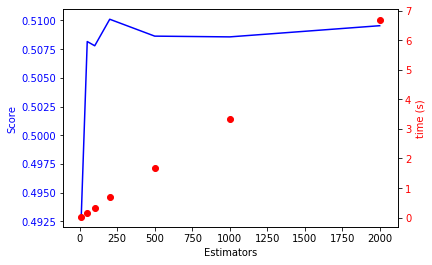

In [8]:
#muting warnings from here on out
warnings.simplefilter("ignore")

scores = []
times = []
estimators = [10,50,100,200,500,1000,2000]#,5000,10000] #Can add some serious time.
for esimator in estimators:
    print('Training with',esimator)
    t1 = time.clock()
    regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=esimator)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    times.append(time.clock() - t1)

#Plot Results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Estimators')
ax1.set_ylabel('Score', color='b')
ax1.plot(estimators, scores, color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)', color='r')
ax2.scatter(estimators, times, color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()


---

## Depth of Trees


Now let's look at the affect of changing `max_depth` or the maximum depth of the trees in our forest. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

Training with 2
Training with 5
Training with 10
Training with 20
Training with 30
Training with 40
Training with None


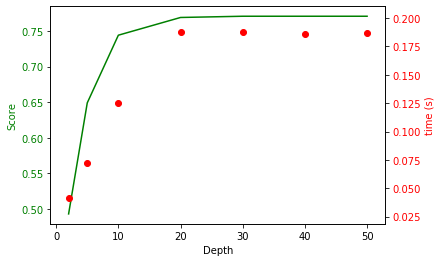

In [9]:
scores = []
times = []
depths = [2,5,10,20,30,40,None]
for depth in depths:
    print('Training with',depth)
    t1 = time.clock()
    regr = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=10)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    times.append(time.clock() - t1)

#Replace None for purpose of plot
depths = [x if x != None else 50 for x in depths ]
    
#Plot Results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Depth')
ax1.set_ylabel('Score', color='g')
ax1.plot(depths, scores, color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)', color='r')
ax2.scatter(depths, times, color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()

---

## Random State


`random_state` controls two items in a random forest model: the randomness of the samples that each tree gets with boostraping & the selection of features to consider when looking to split at each node. `None`(default) uses `np.random` but if we want our model to produce the same result when runnning multiple times (ie deterministic) we can use an integer to seed a random number generator. `0` and `42` are commonly used.

Training with 0
Training with 3
Training with 7
Training with 41
Training with 42
Training with 43
Training with None
Training with None
Training with None
Training with None
Training with None
Training with None


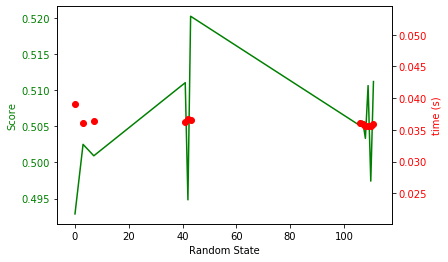

In [10]:
scores = []
times = []
randomness = [0,3,7,41,42,43,None,None,None,None,None,None]
for rand in randomness:
    print('Training with',rand)
    t1 = time.clock()
    regr = RandomForestRegressor(max_depth=2, random_state=rand, n_estimators=10)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    times.append(time.clock() - t1)

#Replace None for purpose of plot
randomness = [x if x != None else 100+i for i,x in enumerate(randomness)]
    
#Plot Results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Random State')
ax1.set_ylabel('Score', color='g')
ax1.plot(randomness, scores, color='g')
ax1.tick_params(axis='y', labelcolor='g')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)', color='r')
ax2.scatter(randomness, times, color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()

Notice the changes in score? What happens when we do not seed the random number generator?

---

## Max Features
`max_features` or the maximum number of features considered for splitting a node. This parameter also take special case strings: `'auto'`(default),`'sqrt'`, `'log2'`, `None`(default).  Generally, by having "dumb" trees you increase the variety of trees allowing for different features to show through the dominant features.

Training with 2
Training with 5
Training with 10
Training with 11
Training with auto
Training with sqrt
Training with log2
Training with None


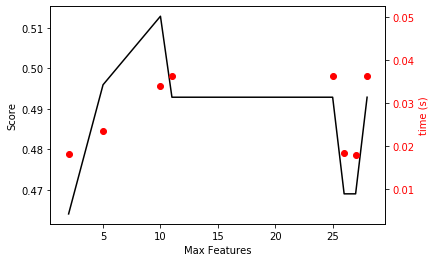

In [11]:
scores = []
times = []
max_features = [2,5,10,X.shape[1],'auto','sqrt','log2',None]
for mx in max_features:
    print('Training with',mx)
    t1 = time.clock()
    regr = RandomForestRegressor(max_depth=2, max_features=mx,random_state=0, n_estimators=10)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    times.append(time.clock() - t1)

#Replace Strings and None for purpose of plot
max_features = [x if x != None else 28 for x in max_features]
max_features = [x if x != 'log2' else 27 for x in max_features ]
max_features = [x if x != 'sqrt' else 26 for x in max_features ]
max_features = [x if x != 'auto' else 25 for x in max_features ]

    
#Plot Results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Max Features')
ax1.set_ylabel('Score', color='k')
ax1.plot(max_features, scores, color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)', color='r')
ax2.scatter(max_features, times, color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()

What was the optimum maximum? Remember that 25-28 are the special cases.

---
## Min Features
`min_samples_split` or the minimum number of samples required to split an internal node.

Training with 2
Training with 3
Training with 4
Training with 5


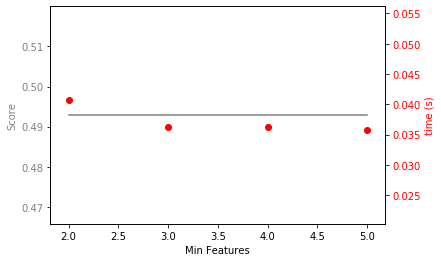

In [12]:
scores = []
times = []
min_features = [2,3,4,5]
for mn in min_features:
    print('Training with',mn)
    t1 = time.clock()
    regr = RandomForestRegressor(max_depth=2, min_samples_split=mn, random_state=0, n_estimators=10)
    regr.fit(X_train, y_train)
    scores.append(regr.score(X_test, y_test))
    times.append(time.clock() - t1)

#Replace Strings for purpose of plot
min_features = [x if x != 'log2' else 27 for x in min_features ]
min_features = [x if x != 'sqrt' else 26 for x in min_features ]
min_features = [x if x != 'auto' else 25 for x in min_features ]

    
#Plot Results
fig, ax1 = plt.subplots()

ax1.set_xlabel('Min Features')
ax1.set_ylabel('Score', color='grey')
ax1.plot(min_features, scores, color='grey')
ax1.tick_params(axis='y', labelcolor='grey')

ax2 = ax1.twinx()

ax2.set_ylabel('time (s)', color='r')
ax2.scatter(min_features, times, color='r')
ax2.tick_params(axis='y', labelcolor='r')
plt.show()

In this case we see that changing the minimum number of features to split a node doesn't have a positive affect on our model.

---

These relationships are not always independent and you can also test them against each other to get the most out of your model. 
 
 ### NOTE:
 *If you <font color='red'>are not</font> running a faster computer **skip** the cell below and **load** the data with the cell below it.*

In [ ]:
#************************************************************************************************#
#To run it yourself run this cell
depths = list(range(2,21))
trees = list(range(10,2000,100))
trees = [2,3,4,5,6,7,8,9,10,25,50,75,100,150,200,250,500,1000,1500,2000]


xa = np.array([depths]*20).T
ya = np.array([trees]*19)

Z_s = []
Z_t = []
for depth in depths:
    z_s = []
    z_t = []
    for tree in trees:
        t1 = time.clock()
        regr = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=tree, n_jobs=-1)
        regr.fit(X_train, y_train)
        z_t.append(time.clock() - t1)
        z_s.append(regr.score(X_test, y_test))
    Z_s.append(z_s)
    Z_t.append(z_t)

Z_t = np.array(Z_t)
Z_s = np.array(Z_s)
#************************************************************************************************#

In [13]:
#To load the pre-completed data from the cell above run this cell
depths = list(range(2,21))
trees = [2,3,4,5,6,7,8,9,10,25,50,75,100,150,200,250,500,1000,1500,2000]

xa = np.array([depths]*20).T
ya = np.array([trees]*19)

Z_t = np.loadtxt("data/Z_t.out")
Z_s = np.loadtxt("data/Z_s.out")

In [14]:
#Change some plotting settings
from mpl_toolkits.mplot3d import axes3d

%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


<IPython.core.display.Javascript object>


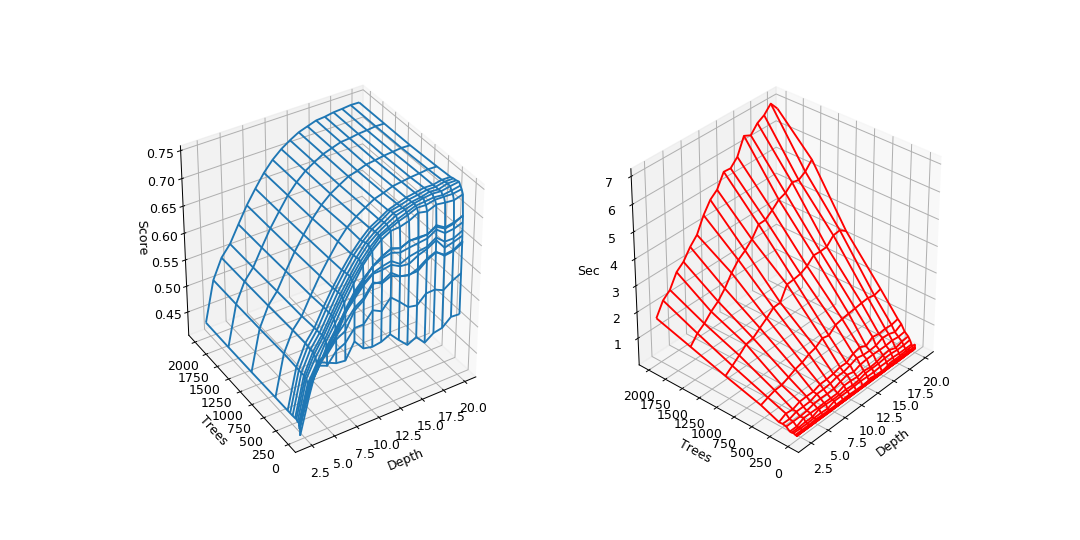

In [15]:
#Plot data
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(xa, ya, Z_s, rstride=1, cstride=1)
ax.set_xlabel('Depth')
ax.set_ylabel('Trees')
ax.set_zlabel('Score')

ax1 = fig.add_subplot(122, projection='3d')
ax1.plot_wireframe(xa, ya, Z_t, rstride=1, cstride=1,color='r')
ax1.set_xlabel('Depth')
ax1.set_ylabel('Trees')
ax1.set_zlabel('Sec')
plt.show()

Drag points on the models to rotate them. 
- Notice the plateau in the score that we reach around 250 trees?  
- Notice that the influence of the depth of the trees decreases with the increaded number of trees? 

---

# Give it a try

With what we learned let's retrain our model. Pick inputs from what we learned above and retrain the model.  
- Adjust and try it again.
- Better or worse score?
- Was there a decrease or increase of training time?

By setting `n_jobs` to `-1` we can speed this up by using all processors.

In [16]:
subset = labels + pn_usable

las_df.dropna(subset=subset, inplace=True)

X = las_df[labels]
y = las_df[pn_usable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

t1 = time.clock()

##Enter your values
regr = RandomForestRegressor(max_depth=10 ,  n_estimators=175 , max_features='sqrt' , random_state=42 , n_jobs=-1)

regr.fit(X_train, y_train)
print('Model Score:',round(regr.score(X_test, y_test),3),'in',round(time.clock() - t1,3),'sec') 

Model Score: 0.704 in 0.352 sec


So we've just about doubled our model's score showing the importance of hyperameter tuning.

---


# Saving & Loading

So you want to deploy your model but don't want to train it every time?


In [17]:
from joblib import dump, load

#Saving Model
dump(regr, 'regr.joblib')

#Loading Model
regr2 = load('regr.joblib') 

Let's take a look at how you would deploy it to make predictions. Let's load a log that the model hasn't seen before and see how it does...

In [18]:
#Load
las2 = lasio.read("data/Logs/0512338763_3599412.las.txt")
las_df2 = las2.df()

#Drop Null Values
subset = labels + pn_usable
las_df2.dropna(subset=subset, inplace=True)

#Run Model
X = las_df2[labels][las_df2[labels].notnull()]
y_pred = regr2.predict(X)

#Write Predictions to the DF
new_cols = [x.split('_')[0] for x in pn_usable]

for i,col in enumerate(new_cols):
    las_df2[col] = y_pred[:,i]

<IPython.core.display.Javascript object>


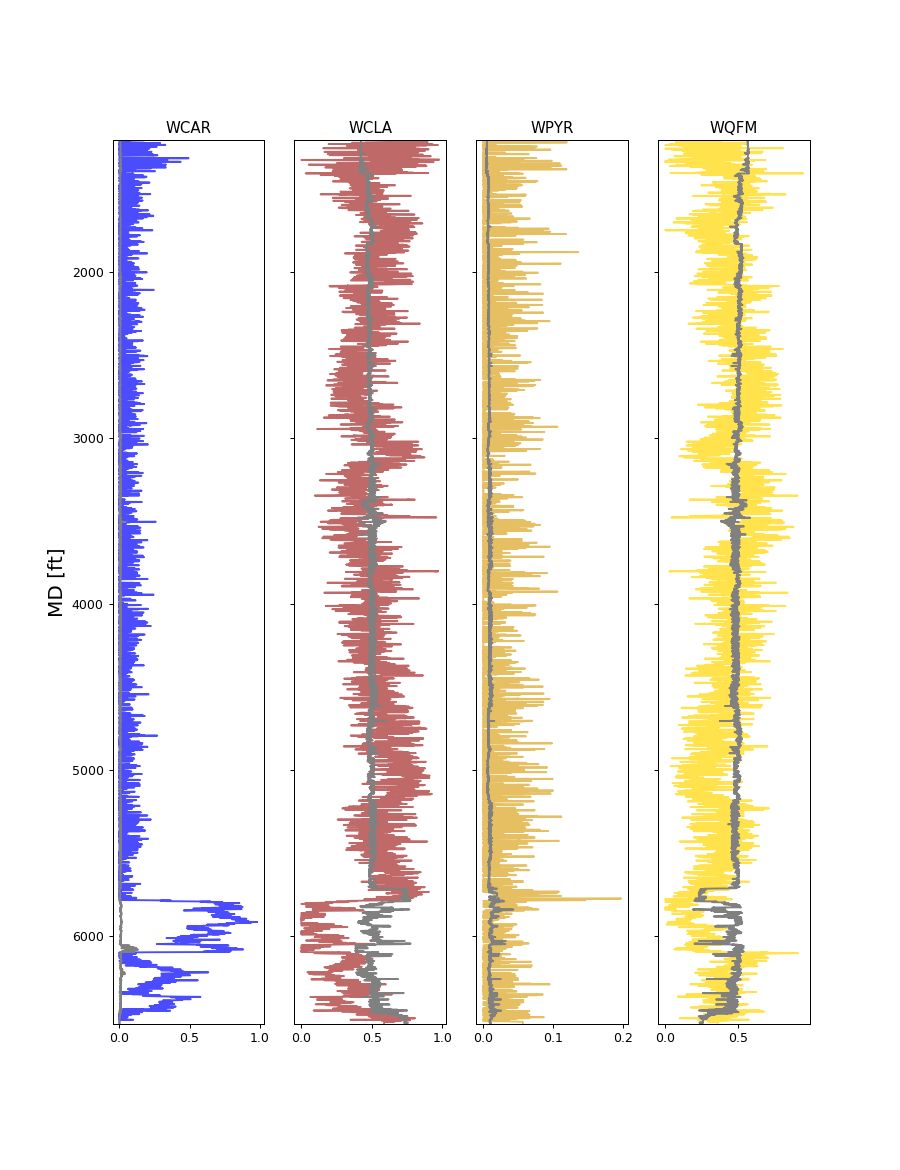

Text(0, 0.5, 'MD [ft]')

In [19]:
#Plot the results
c = ['blue','brown','goldenrod','gold']
x = las_df2
ztop=x.index.min(); zbot=x.index.max()

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(10, 13))
for i,col in enumerate(new_cols):
    ax[i].set_ylim(ztop,zbot)
    ax[i].plot(x[col+'_WALK2'],x.index,color=c[i],alpha=0.7)
    ax[i].plot(x[col],x.index,color='grey')
    ax[i].set_title(col)
    ax[i].invert_yaxis()
    ax[i].grid(b=False)
    if i !=0:
        ax[i].set_yticklabels([])
ax[0].set_ylabel('MD [ft]', fontsize=16)

- Where is your model working? 
- Where is it not?
- What could be done to improve the model?
- How do you think changes in fluids affects the model?